In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
from pylab import rcParams

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 314

/usr/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
columns = ['user','activity','timestamp', 'x', 'y', 'z']
df = pd.read_csv('data/WISDM_ar_v1.1_raw.txt', lineterminator=';', header=None, names=columns)
df.head()

/usr/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,user,activity,timestamp,x,y,z
0,33,Jogging,4.910596e+13,-0.694638,12.680544,0.503953
1,33,Jogging,4.910606e+13,5.012288,11.264028,0.953424
2,33,Jogging,4.910611e+13,4.903325,10.882658,-0.081722
3,33,Jogging,4.910622e+13,-0.612916,18.496431,3.023717
4,33,Jogging,4.910633e+13,-1.184970,12.108489,7.205164


/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


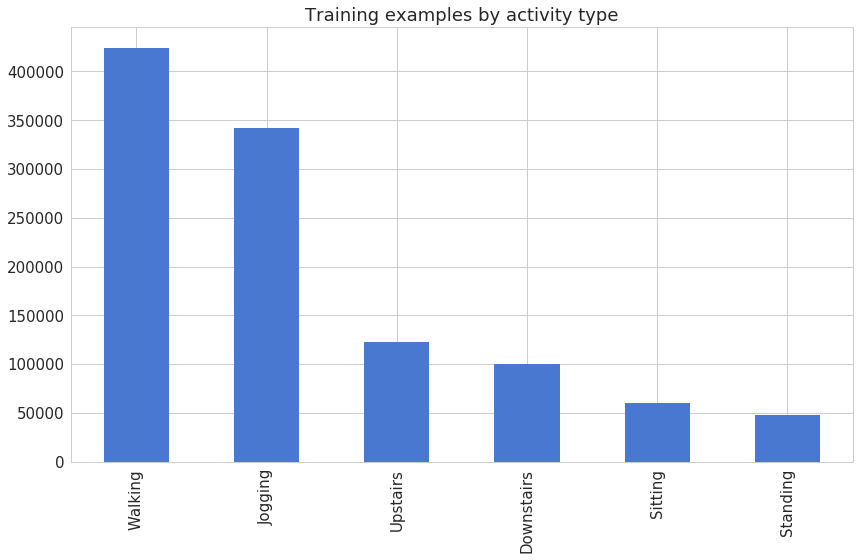

In [3]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type')

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


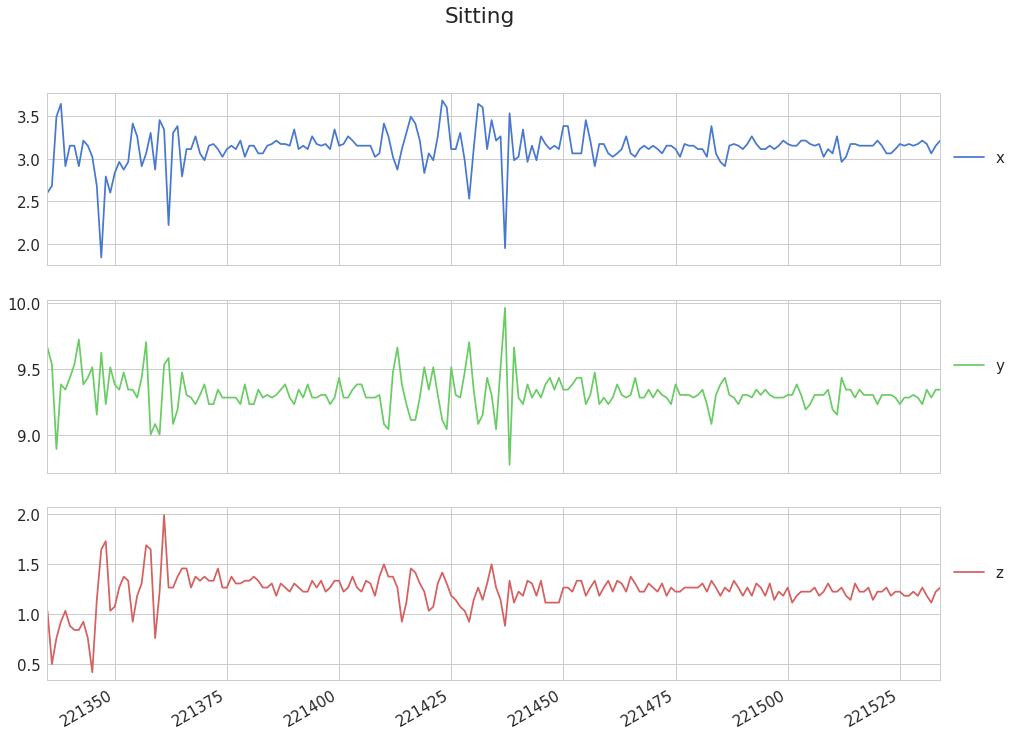

In [4]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x', 'y', 'z']][:200]
    axis = data.plot(subplots=True, title=activity, figsize=(16, 12))

    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

plot_activity('Sitting', df)

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


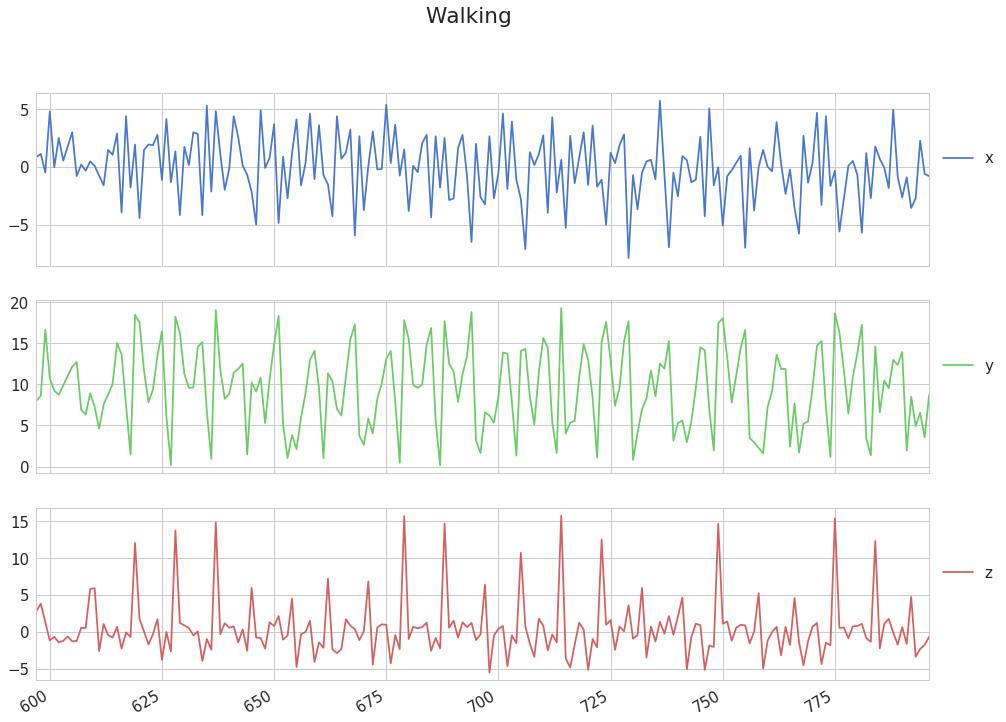

In [5]:
plot_activity('Walking', df)

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


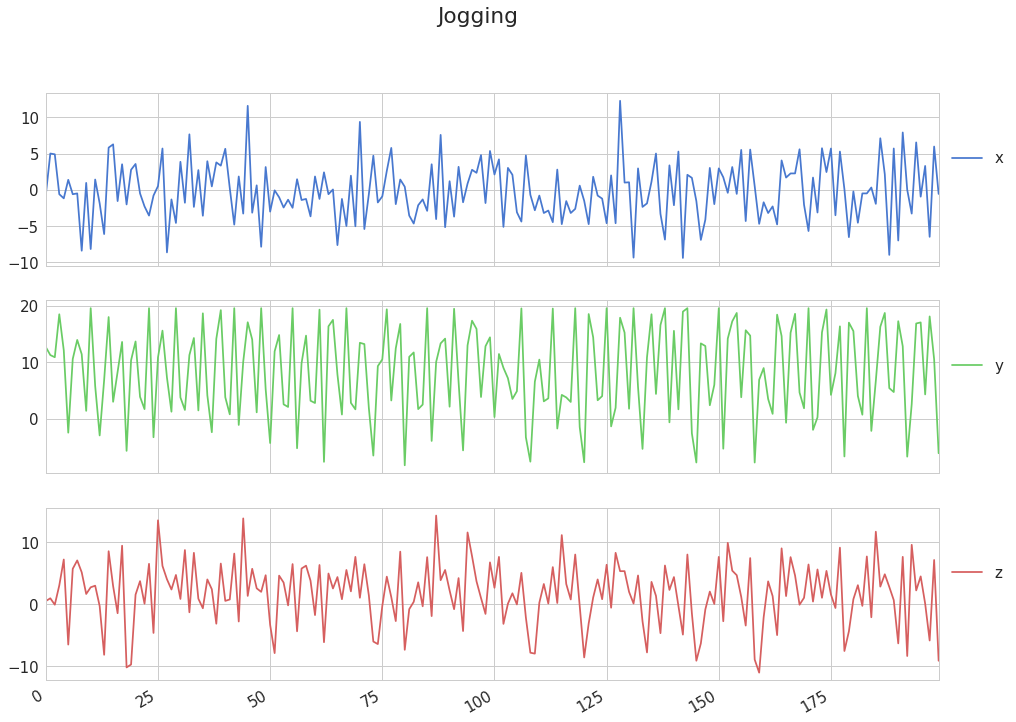

In [6]:
plot_activity('Jogging', df)

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


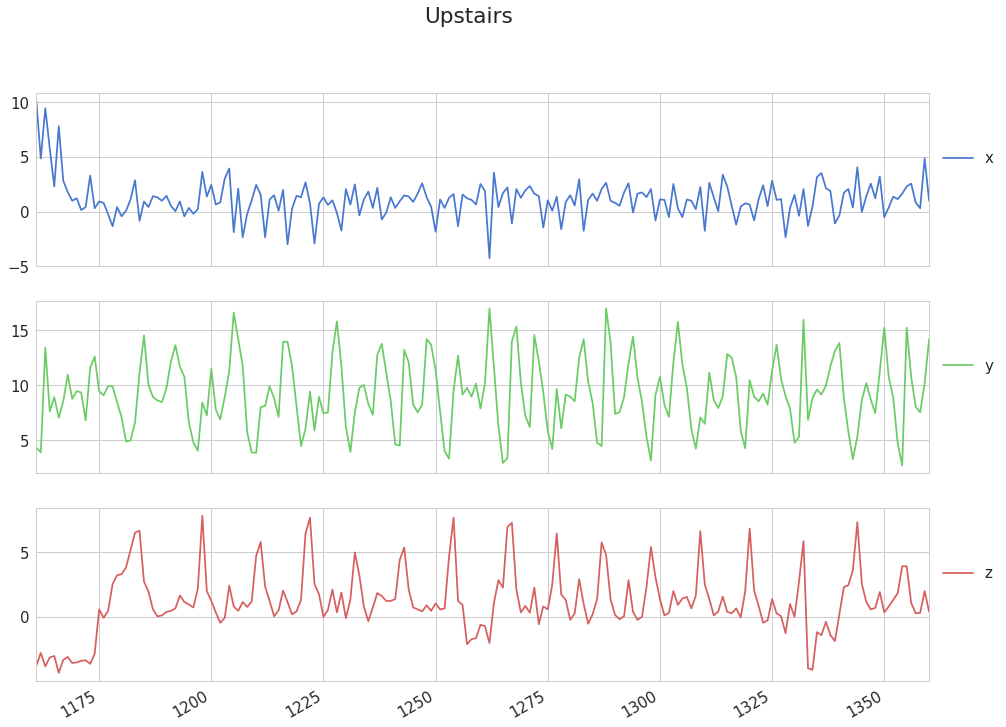

In [7]:
plot_activity('Upstairs', df)

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


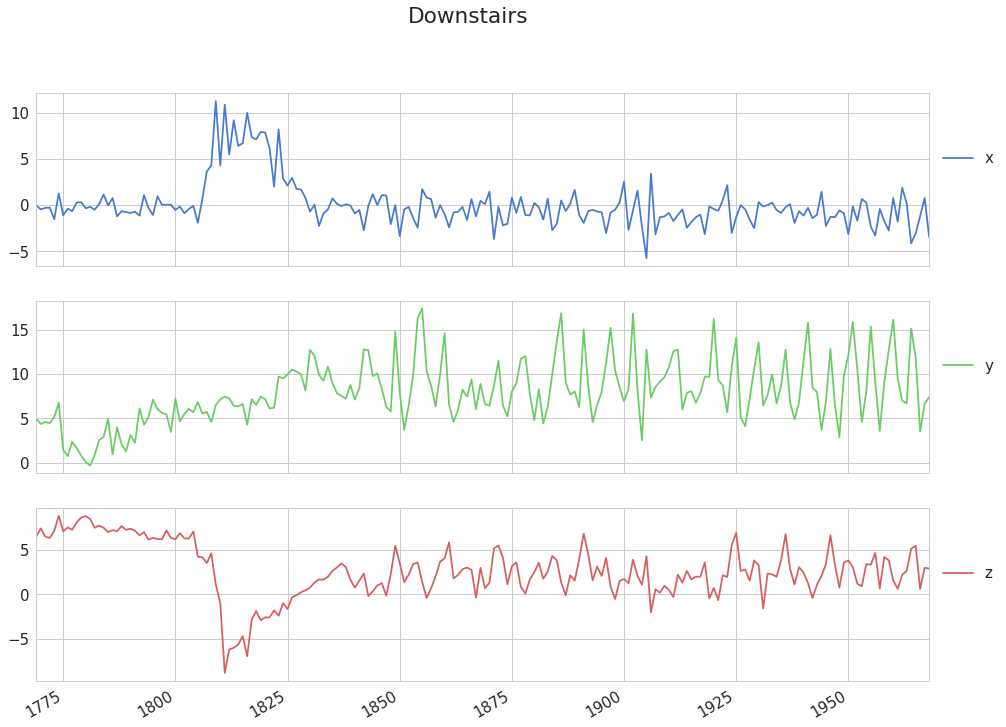

In [8]:
plot_activity('Downstairs', df)

In [9]:
# data preprocessing
N_TIME_STEPS = 150
N_FEATURES = 3

step = 20
segments = []
labels = []

for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x'].values[i:i + N_TIME_STEPS]
    ys = df['y'].values[i:i + N_TIME_STEPS]
    zs = df['z'].values[i:i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i:i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype=np.float32)

X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

/home/sammy/work/deep-learning-cuda/lib/python3.6/site-packages/scipy/stats/stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [10]:
# building the model
N_CLASSES = 6
N_HIDDEN_UNITS = 64

rand_norm_var = lambda shape: tf.Variable(tf.random_normal(shape))

# REMOVE ME
def create_model(inputs):
    W = {'hidden': rand_norm_var([N_FEATURES, N_HIDDEN_UNITS]),
         'output': rand_norm_var([N_HIDDEN_UNITS, N_CLASSES])}

    B = {'hidden': rand_norm_var([N_HIDDEN_UNITS]),
         'output': rand_norm_var([N_CLASSES])}

    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + B['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

#    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = [tf.contrib.rnn.GRUCell(N_HIDDEN_UNITS) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + B['output']

In [11]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name='input')
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

pred_Y = create_model(X)
pred_softmax = tf.nn.softmax(pred_Y, name='y_')

In [12]:
L2_LOSS = 0.0015
l2 = L2_LOSS * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred_Y, labels=Y)) + l2

LEARNING_RATE = 0.0015
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

In [13]:
# TRAINING
N_EPOCHS = 50
BATCH_SIZE = 1024

saver = tf.train.Saver()

history = dict(train_loss = [], train_acc = [], test_loss = [], test_acc = [])

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

# just for fun, run in on non-trained network
_, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})
print(f'epoch: 0 test accuracy: {acc_test} loss: {loss_test}')

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1, BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_train, Y: y_train})
    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')

epoch: 0 test accuracy: 0.34587013721466064 loss: 5.364755630493164
epoch: 1 test accuracy: 0.7783442139625549 loss: 1.595374584197998
epoch: 2 test accuracy: 0.8510152101516724 loss: 1.3508950471878052
epoch: 3 test accuracy: 0.8819776773452759 loss: 1.2468624114990234
epoch: 4 test accuracy: 0.8934521079063416 loss: 1.186631441116333
epoch: 5 test accuracy: 0.9125759601593018 loss: 1.0952883958816528
epoch: 6 test accuracy: 0.9072942137718201 loss: 1.0909584760665894
epoch: 7 test accuracy: 0.9293321967124939 loss: 1.0018229484558105
epoch: 8 test accuracy: 0.9286948442459106 loss: 0.9711399078369141
epoch: 9 test accuracy: 0.9388031363487244 loss: 0.9250310659408569
epoch: 10 test accuracy: 0.9439029097557068 loss: 0.8785862326622009
epoch: 11 test accuracy: 0.9448134899139404 loss: 0.8519178628921509
epoch: 12 test accuracy: 0.9474545121192932 loss: 0.8374279737472534
epoch: 13 test accuracy: 0.9484561681747437 loss: 0.8118456602096558
epoch: 14 test accuracy: 0.935797929763794 los

In [14]:
predictions, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})
print(f'final results: test accuracy: {acc_test} loss: {loss_test}')

final results: test accuracy: 0.9600216150283813 loss: 0.43996360898017883


In [15]:
# TODO: save & restore

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


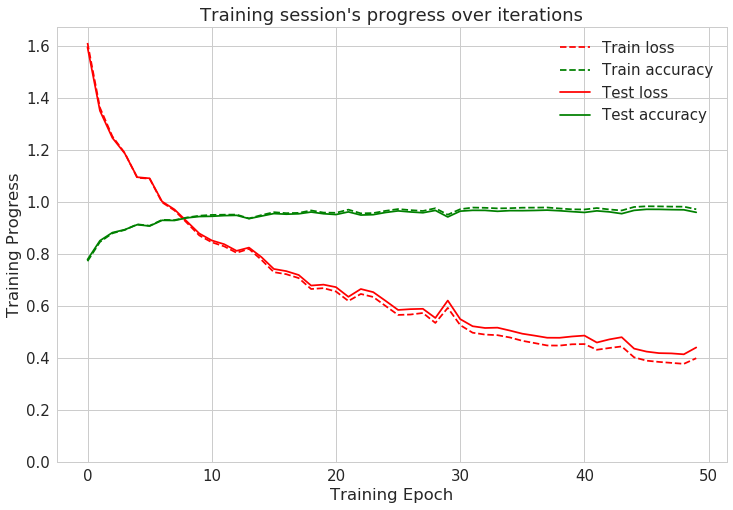

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")
plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


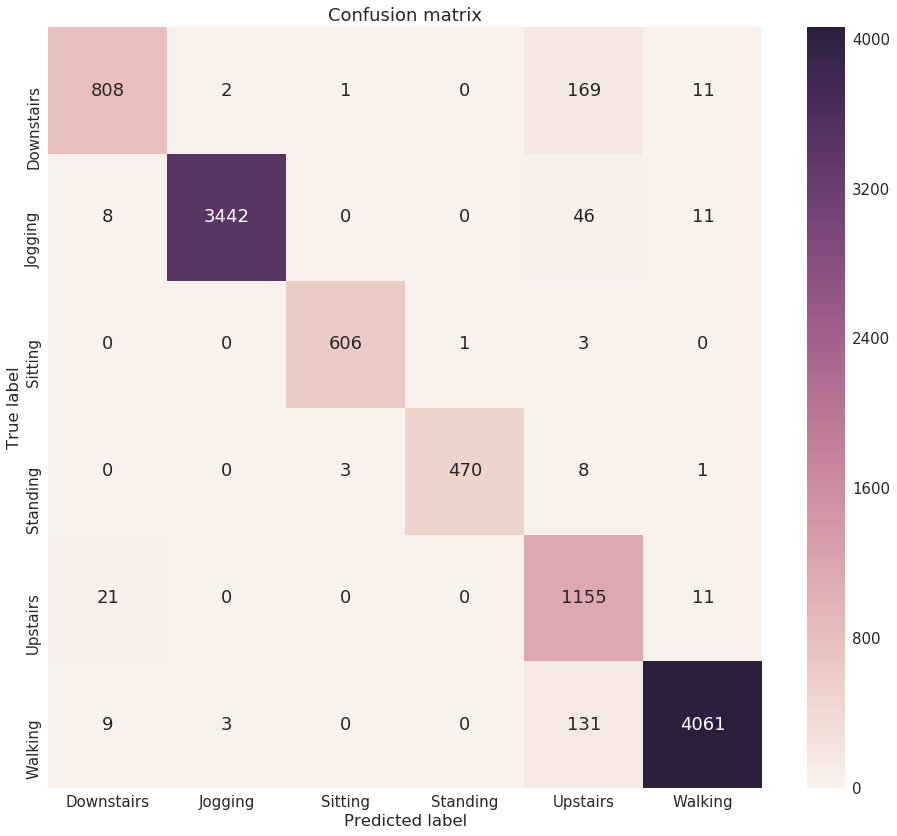

In [17]:
LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

In [18]:
#sess.close()